In [1]:
import csv
from sklearn.model_selection import train_test_split
import pandas as pd

# Read the input data
input_data = input("Enter the path to the dataset CSV file: ")

#Add severity column index
si = int(input("Enter the severity column index: "))
# 4 - stats19, 15 - crss, 1 - onisr

# load data from CSV file using a CSV reader
data = []
severity = []
with open(input_data, newline='') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    header = next(reader) # skip the header row
    for row in reader:
        data.append(row[0:si-1] + row[si+1:-1])
        severity.append(row[si])

# split data into training and test sets
data_train, data_test, severity_train, severity_test = train_test_split(
    data, severity, test_size=0.25, stratify=severity, random_state=42)

print(len(data_test), len(data_train))
print(len(severity_test), len(severity_train))
print("Severity distribution in train:")
print(str(pd.Series(severity_test).value_counts()))
print("Severity distribution in train:")
print(str(pd.Series(severity_test).value_counts()))

Enter the path to the dataset CSV file: /Users/islambabaev/Google Drive/Programming/HARA Automation/stats19_analysis/data_for_cat.csv
Enter the severity column index: 4
126775 380323
126775 380323
Severity distribution in train:
1    103963
2     21787
3      1025
dtype: int64
Severity distribution in train:
1    103963
2     21787
3      1025
dtype: int64


In [2]:
from catboost import CatBoostClassifier
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
import pandas as pd
import numpy as np

# Ask the user to select from three different options
print("Please select a dataset balancing option:")
print("Type 1 for weighted balancing")
print("Type 2 for oversampled balancing")
print("Type 3 for undersampled balancing")

# Get the user's input
user_input = input("Enter your choice: ")

# Handle the user's input using conditional statements

if user_input == "1":
    print("You selected weighted balancing")
    # Training our classifier with weighted severity classes
    unique_classes = np.unique(severity_train)
    class_weights = [1 / pd.Series(severity_train).value_counts()[cls] for cls in unique_classes]
    model = CatBoostClassifier(iterations=50, early_stopping_rounds=10, class_weights=class_weights, random_state=42, verbose=500)
    model.fit(data_train, severity_train, eval_set=(data_test, severity_test))
    model.save_model('weighed_catboost_model.cbm')

elif user_input == "2":
    print("You selected oversampled balancing")
    # Create a RandomOverSampler object
    oversampler = RandomOverSampler(random_state=42)
    # Resample the training data and labels
    data_train_resampled, severity_train_resampled = oversampler.fit_resample(data_train, severity_train)
    model = CatBoostClassifier(iterations=50, early_stopping_rounds=10, class_weights=class_weights, random_state=42, verbose=500)
    model.fit(data_train_resampled, severity_train_resampled, eval_set=(data_test, severity_test))
    model.save_model('oversampled_catboost_model.cbm')

elif user_input == "3":
    print("You selected undersampled balancing")
    # Create a RandomUnderSampler object
    undersampler = RandomUnderSampler(random_state=42)
    # Resample the training data and labels
    data_train_resampled_us, severity_train_resampled_us = undersampler.fit_resample(data_train, severity_train)    
    model = CatBoostClassifier(iterations=50, early_stopping_rounds=10, class_weights=class_weights, random_state=42, verbose=500)
    model.fit(data_train_resampled, severity_train_resampled, eval_set=(data_test, severity_test))
    model.save_model('undersampled_catboost_model.cbm')    

else:
    print("Invalid choice. Please select a number between 1 and 3.")

Please select a dataset balancing option:
Type 1 for weighted balancing
Type 2 for oversampled balancing
Type 3 for undersampled balancing
Enter your choice: 1
You selected weighted balancing
Learning rate set to 0.381878
0:	learn: 1.0426772	test: 1.0457753	best: 1.0457753 (0)	total: 135ms	remaining: 6.6s
49:	learn: 0.9028192	test: 0.9525709	best: 0.9525709 (49)	total: 2.78s	remaining: 0us

bestTest = 0.9525708655
bestIteration = 49



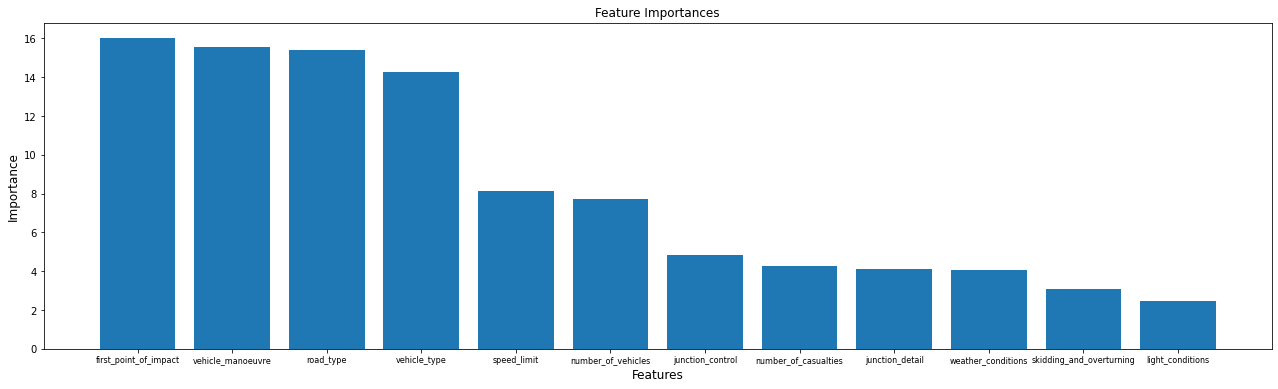

In [3]:
import matplotlib.pyplot as plt

# Assuming you have feature names in a list called 'feature_names'
feature_names = header[0:si] + header[si+1:]

# Get feature importances from the trained model
feature_importances = model.feature_importances_

# Sort feature importances and their corresponding feature names in descending order
sorted_indices = feature_importances.argsort()[::-1]
sorted_feature_importances = feature_importances[sorted_indices]
sorted_feature_names = [feature_names[i] for i in sorted_indices]

# Create a bar chart with feature importances
plt.figure(figsize=(22, 6))
plt.bar(sorted_feature_names, sorted_feature_importances)
plt.xticks(fontsize=8)  # Change the font size of the x-axis labels
plt.xlabel('Features', fontsize=12)
plt.ylabel('Importance', fontsize=12)
plt.title('Feature Importances')

# Display the chart
plt.show()

In [4]:
#Printing features of the classifier with weighted severity classes
accuracy = model.score(data_test, severity_test)
print(accuracy)

"""
A confusion matrix is a performance evaluation tool used in CatBoost, which is a gradient boosting machine learning algorithm.
The confusion matrix is a table that shows the number of true positives, true negatives, false positives, and false negatives for a given binary classification problem.
In the context of CatBoost, the confusion matrix is generated by comparing the predicted labels of the model to the actual labels in the test dataset.
The true positives (TP) represent the number of instances where the model predicted a positive label and the actual label was also positive.
The true negatives (TN) represent the number of instances where the model predicted a negative label and the actual label was also negative.
The false positives (FP) represent the number of instances where the model predicted a positive label, but the actual label was negative.
The false negatives (FN) represent the number of instances where the model predicted a negative label, but the actual label was positive.
"""

from sklearn.metrics import confusion_matrix
test_result = model.predict(data_test, prediction_type='Class')

#calculating confusion matrix
cm = confusion_matrix(severity_test, test_result)
print(cm)

"""
The confusion_matrix function output

                Predicted
             S1    S2    S3
    Actual  -----------------
      S1   | TP1 | FP1 | FP2 |
      S2   | FP3 | TP2 | FP4 |
      S3   | FP5 | FP6 | TP3 |

TP1 represents the number of instances that are correctly classified as S1,
FP1 represents the number of instances that are incorrectly classified as class S2 when they actually belong to class S1,
FP2 represents the number of instances that are incorrectly classified as class S3 when they actually belong to class S1,
and so on.
"""

from sklearn.metrics import classification_report
report = classification_report(severity_test, test_result)
print(report)

"""
roc_auc_score is a performance metric used in CatBoost, which is a gradient boosting machine learning algorithm.
The roc_auc_score is a measure of how well the algorithm is able to distinguish between two classes in a binary classification problem.
The term "ROC" stands for Receiver Operating Characteristic, which is a curve that plots the true positive rate against the false positive rate for a given classification model.
The area under this curve is referred to as the "ROC AUC" score, and is used to evaluate the performance of a binary classification model.
In CatBoost, the roc_auc_score is used to evaluate the performance of the model on the test dataset.
A higher roc_auc_score indicates that the model is better able to distinguish between the positive and negative classes in the test dataset, and therefore has a higher predictive accuracy.
This metric is particularly useful when dealing with imbalanced datasets, where one class is much more prevalent than the other, as it provides a more robust measure of performance than simply looking at accuracy or precision.
"""

from sklearn.metrics import roc_auc_score
proba_test_result = model.predict_proba(data_test)
n_classes = len(model.classes_)

import numpy as np
acc_cons = np.sum(np.triu(cm)/np.sum(cm))
print(f'conservative_accuracy {acc_cons}')

#calcularing roc_auc_score
auc_roc = roc_auc_score(severity_test, proba_test_result, multi_class='ovr', average='macro')
print(auc_roc)

0.5506842831788602
[[61020 25894 17049]
 [ 7568  8152  6067]
 [  168   216   641]]
              precision    recall  f1-score   support

           1       0.89      0.59      0.71    103963
           2       0.24      0.37      0.29     21787
           3       0.03      0.63      0.05      1025

    accuracy                           0.55    126775
   macro avg       0.38      0.53      0.35    126775
weighted avg       0.77      0.55      0.63    126775

conservative_accuracy 0.937274699270361
0.6842971678752295


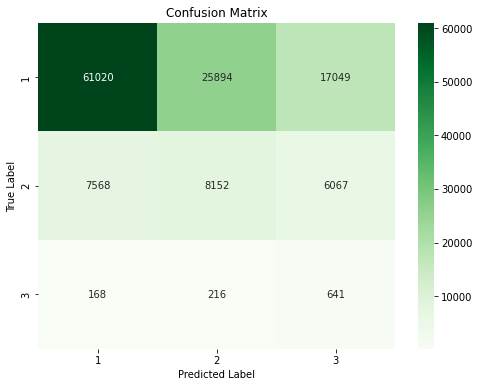

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc
import numpy as np

# Function to plot confusion matrix heatmap
def plot_confusion_matrix(cm, class_labels):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')

# Plot confusion matrix heatmap
plot_confusion_matrix(cm, model.classes_)

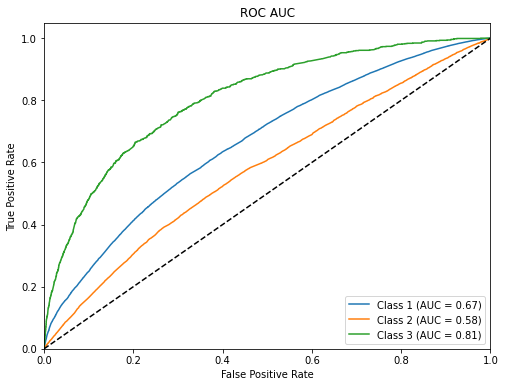

In [6]:
# Function to plot ROC AUC curves for each class
import numpy as np
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize

# Convert target labels to binary format using one-hot encoding
y_test_bin = label_binarize(severity_test, classes=model.classes_)

# Obtain predicted probabilities
y_probs = model.predict_proba(data_test)

# Compute ROC curve and ROC AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = len(model.classes_)
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC AUC curves
plt.figure(figsize=(8, 6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {model.classes_[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC AUC')
plt.legend(loc="lower right")
plt.show()
